In [1]:
import sys
sys.path.append("/home/azhuavlev/PycharmProjects/ml-neuman_mano/pytorch3d_nerf")

%load_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader
from datasets import dataset_extr_to_mano
import glob
import os
import glob
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pytorch3d
import sys
import time
import torch
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# disable pytorch gradient computation
torch.set_grad_enabled(False)

data_path = '/home/azhuavlev/Desktop/Data/InterHand_Neuman/03'
all_ids = list(range(len(glob.glob(os.path.join(data_path, 'cameras', '*.json')))))

# use 80% of the data for training, randomize the order
np.random.shuffle(all_ids)

full_dataset = dataset_extr_to_mano.NeumanDataset(data_path, all_ids, bg_rm_dilation= -1)

# We sample 6 random cameras in a minibatch.
batch_size = 1

full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

Fix shapedirs bug of MANO
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not found in mano
pose_id not 

In [3]:
# get example batch
batch = next(iter(full_loader))
camera_params, images, silhouettes, silhouettes_can, manos = batch
print('images.shape', images.shape)

images.shape torch.Size([1, 512, 334, 3])


Text(0.5, 1.0, 'Silhouette')

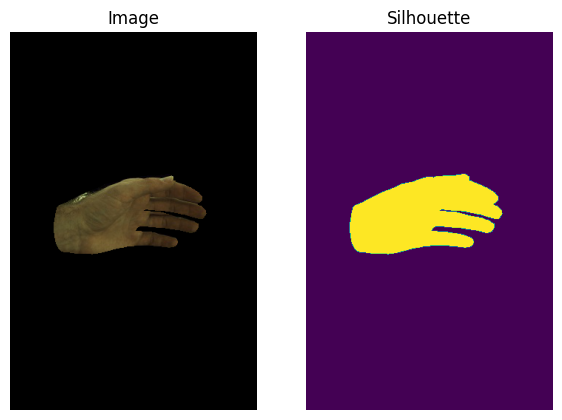

In [6]:
# plot images[0] and silhouettes[0]
plt.figure(figsize=(7, 7))
plt.subplot(1, 2, 1)
plt.imshow(images[0].cpu().numpy())
plt.grid(False)
plt.axis('off')
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(silhouettes[0].cpu().numpy())
plt.grid(False)
plt.axis('off')
plt.title('Silhouette')

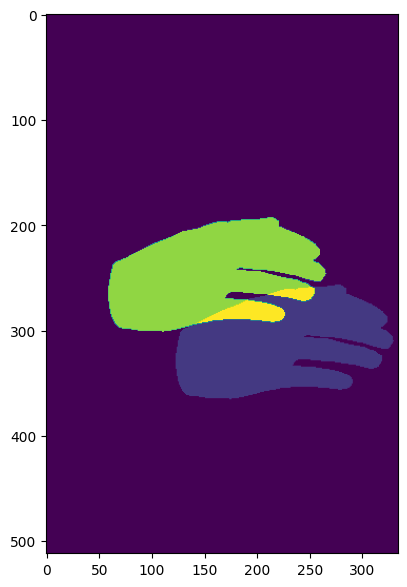

In [8]:
patch_size = 64
# shift the silhouette by patch_size to the right and down
silhouette_shifted = torch.zeros_like(silhouettes[0])
silhouette_shifted[patch_size:, patch_size:] = silhouettes[0, :-patch_size, :-patch_size]
# plot the shifted silhouette

silhouette_shifted = silhouette_shifted + silhouettes[0] * 5

plt.figure(figsize=(7, 7))
plt.imshow(silhouette_shifted.cpu().numpy())


In [42]:
import kornia.morphology as kmorph

sil_dilated = kmorph.dilation(
        silhouettes.unsqueeze(1), kernel=torch.ones(25, 25, device=silhouettes.device))

patch_size = 64

%matplotlib notebook
sil_shifted_up = torch.zeros_like(silhouettes[0])
sil_shifted_up[:-patch_size//2, :-patch_size//2] = sil_dilated[0, 0, patch_size//2:, patch_size//2:]

# find intersection of sil_dilated and sil_shifted_up
sil_intersection = sil_dilated[0, 0] * sil_shifted_up

plt.figure(figsize=(7, 7))
ax = plt.subplot(1, 3, 1)
ax.imshow(sil_dilated[0, 0].cpu().numpy() + sil_shifted_up.numpy())
ax.grid(which='major', axis='both', linestyle='-')

ax = plt.subplot(1, 3, 2)
ax.imshow(sil_intersection.cpu().numpy())
ax.grid(which='major', axis='both', linestyle='-')

# print('sil_intersection', sil_intersection.shape)
# print('images', images.shape)
ax = plt.subplot(1, 3, 3)
sil_intersection_3_ch = sil_intersection.unsqueeze(-1).repeat(1, 1, 3)
ax.imshow(sil_intersection_3_ch * images[0])
ax.grid(which='major', axis='both', linestyle='-')

<IPython.core.display.Javascript object>

In [112]:
sil_intersection_usq = sil_intersection.unsqueeze(0).unsqueeze(0)
eroded_kornia_0_25 = sil_intersection_usq - kmorph.erosion(
    sil_intersection_usq, kernel=torch.ones(25, 25, device=silhouettes.device))
eroded_kornia_25_end = sil_intersection_usq - eroded_kornia_0_25

print('eroded_kornia_0_25', eroded_kornia_0_25.shape)
full_mask_kornia = 3.0 * eroded_kornia_0_25 + 1.0 * eroded_kornia_25_end
full_mask_kornia = full_mask_kornia.squeeze(0).squeeze(0)

plt.imshow(full_mask_kornia.cpu().numpy())
plt.grid(which='major', axis='both', linestyle='-')

eroded_kornia_0_25 torch.Size([1, 1, 512, 334])


In [48]:
full_mask_kornia.sum()

tensor(28424.)

In [111]:
%matplotlib notebook

full_mask_kornia_norm = full_mask_kornia.reshape(1, -1)
# print(full_mask_kornia)
top_left_idx = full_mask_kornia_norm.multinomial(1)

top_left_idx_2d = torch.tensor([top_left_idx // full_mask_kornia.shape[1],
                                top_left_idx % full_mask_kornia.shape[1]])

print('top_left_idx_2d', top_left_idx_2d)

patch = images[0, top_left_idx_2d[0]:top_left_idx_2d[0] + patch_size,
               top_left_idx_2d[1]:top_left_idx_2d[1] + patch_size, :]
print(patch.shape)

patch_mask = torch.zeros_like(full_mask_kornia)
patch_mask[top_left_idx_2d[0]:top_left_idx_2d[0] + patch_size,
           top_left_idx_2d[1]:top_left_idx_2d[1] + patch_size] = 1.0

print(patch_mask.shape)
img_with_patch = torch.max(images[0], patch_mask.unsqueeze(-1).repeat(1, 1, 3))

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(patch)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(img_with_patch)
ax.grid(which='major', axis='both', linestyle='-')
plt.show()

top_left_idx_2d tensor([227, 108])
torch.Size([64, 64, 3])
torch.Size([512, 334])


<IPython.core.display.Javascript object>

In [114]:
import sampling.mask_lpips as mask_lpips
mask_lpips = mask_lpips.sampling_mask_lpips(silhouettes)

print('mask_lpips', mask_lpips.shape)
fig = plt.figure(figsize=(7, 7))
plt.imshow(mask_lpips[0].cpu().numpy())

mask_lpips torch.Size([1, 512, 334])


<IPython.core.display.Javascript object>